## Import modules

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np, pandas as pd
import os.path, os, sys, json, shutil
from pathlib import Path
import math
import scipy
from math import sqrt, log, pi, exp, sinh
from scipy.optimize import curve_fit, leastsq
import matplotlib.gridspec as gridspec
from scipy.signal import argrelextrema
from scipy.interpolate import UnivariateSpline
from scipy.signal import lfilter
from scipy.signal import savgol_filter
from scipy import stats
import os.path
from os import path
plt.rcParams.update({'font.size': 18, 'figure.figsize': [10.0, 8.0]})
workdir=%pwd
print (workdir)

/Users/mikael/github/SI-Lipase-Structure-Factors/manybody/noswap


## Build database of simulation data

In [2]:
# build database of simulation data
db = []
db.append(dict(serie='series2', conf='closed', epslj=0.05, epshh=0.61,
               conc=[0.34, 0.67, 1.24, 2.47, 3.07, 4.2, 5.6, 6.06],
               colors=['#f2bb00', '#e07600', '#cc4400', '#b72300', '#9e0ea9', '#8104ff', '#5a01b5', 'k']))
# add the remaining three sets here...

db = pd.DataFrame(db) # convert to Pandas!
db

,serie,conf,epslj,epshh,conc,colors
0,series2,closed,0.05,0.61,"[0.34, 0.67, 1.24, 2.47, 3.07, 4.2, 5.6, 6.06]","[#f2bb00, #e07600, #cc4400, #b72300, #9e0ea9, ..."


## Plot system energy

Total system energy in function of simulation steps, in order to check that convergence is achieved.

/Users/mikael/github/SI-Lipase-Structure-Factors/manybody/noswap


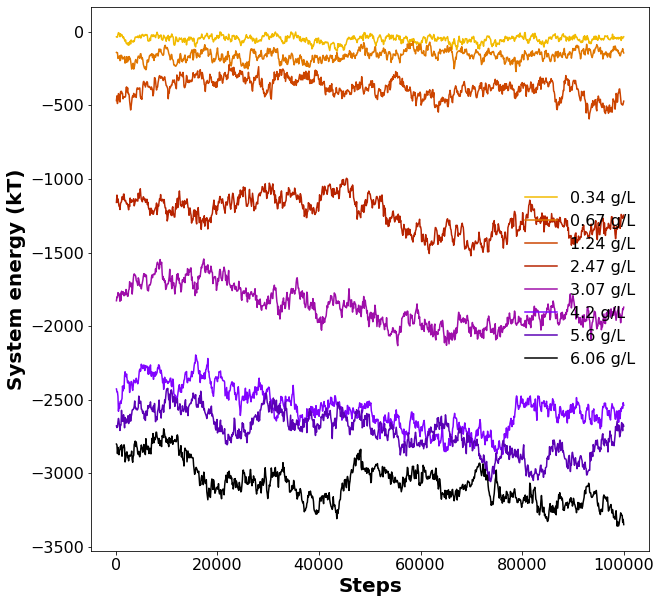

In [3]:
%cd -q $workdir/mc/data
from cycler import cycler
plt.rcParams.update({'font.size': 16, 'figure.figsize': [10.0, 10.0]})
colormap = plt.cm.gnuplot_r
plt.gca().set_prop_cycle('color', plt.cm.gnuplot_r(np.linspace(0.1,1,8)))

series = "series2"
structure = "closed"
epslj = 0.05
epshh = 0.61
dp = 0

for C in [0.34, 0.67, 1.24, 2.47, 3.07, 4.2, 5.6, 6.06]:
    if C == 0.34:
        col = '#f2bb00'
    elif C == 0.67:
        col = '#e07600'
    elif C == 1.24:
        col = '#cc4400'
    elif C == 2.47:
        col = '#b72300'
    elif C == 3.07:
        col = '#9e0ea9'
    elif C == 4.2:
        col = '#8104ff'
    elif C == 5.6:
        col = '#5a01b5'
    elif C == 6.06:
        col='black'
    pfx = str(series)+'-'+str(structure)+'-h'+str(epshh)+'-e'+str(epslj)+'-C'+str(C)+'-dp'+str(dp)
    %cd -q $pfx
    t,e = np.loadtxt("energy.dat",usecols=(0,1),unpack=True)
    plt.plot(t,e,label=str(C)+' g/L')
    plt.xlabel("Steps", fontsize=20, weight='bold')
    plt.ylabel("System energy (kT)", fontsize=20, weight='bold')
    plt.legend(frameon=False)

    %cd -q '..'
            
%cd $workdir

## Plot $S(q)$

Structure factor obtained from the simulations. The average of three repetitions with different displacement parameters is represented by a full line, while the variability is represented by a shaded area.

/Users/mikael/github/SI-Lipase-Structure-Factors/manybody/noswap/mc/data
Missing data for series2-closed-h0.61-e0.05-C6.06-dp2


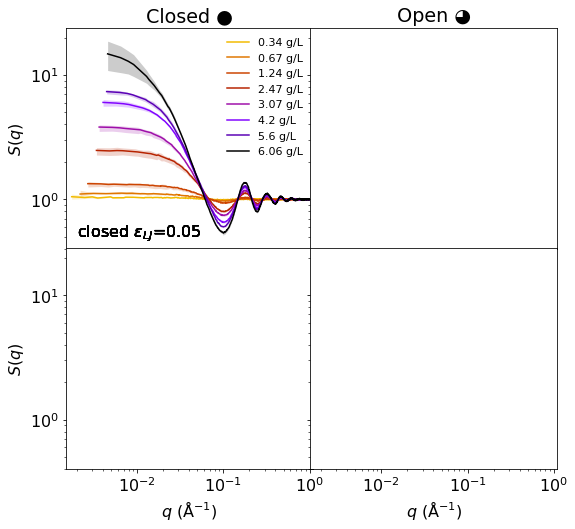

In [20]:
def plot_sofq(ax, data):
    %cd $workdir/mc/data
    color_index=0
    for C in data.conc:
        col = data.colors[color_index]
        color_index+=1
        nriter = 0
        smoy = [0] * 600
        qmoy = [0] * 600
        smax = [0] * 600
        smin = [1000] * 600
        for dp in [0,1,2]:
            #pfx = str(data.serie)+"-"+str(data.conf)+"-h"+str(data.epshh)+"-e"+str(data.epslj)+"-C"+str(C)+"-dp"+str(dp)
            pfx = data.serie+"-"+data.conf+"-h"+str(data.epshh)+"-e"+str(data.epslj)+"-C"+str(C)+"-dp"+str(dp)
            %cd -q $pfx
            if path.exists("debye_n2.dat"):
                q, s = np.loadtxt("debye_n2.dat", unpack=True)
                nriter = nriter + 1   
                for i in np.arange(0,len(q), 1):
                    qmoy[i] = q[i]
                    smoy[i] = smoy[i] + s[i]
                    if smax[i] < s[i]:
                        smax[i] = s[i]
                    if smin[i] > s[i]:
                        smin[i] = s[i]                    
            else:
                print("Missing data for", pfx)
            %cd -q $workdir/mc/data

        for i in np.arange(0,len(q),1):
            smoy[i] = smoy[i]/nriter

        ax.plot(qmoy, smoy, color=col, label='{} g/L'.format(C))
        ax.fill_between(qmoy, smin, smax, interpolate=True, color=col, alpha=0.2, lw=0)
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_ylim(0.4,24)
        ax.set_xlim(0.0015,1.1)
        ax.text(0.002, 0.5, r'{} $\varepsilon_{{LJ}}$={}'.format(data.conf, data.epslj))
        ax.legend(frameon=False, loc=1, fontsize='x-small')
        #np.savetxt(str(data.serie)+"-"+str(data.conf)+"-h"+str(data.epshh)+"-e"+str(data.epslj)+"-C"+str(C)+'_moy.dat',np.transpose((qmoy,smoy)))
        %cd -q $workdir/mc/data

plt.rcParams.update({'font.size': 16, 'figure.figsize': [8.0, 7.0]})
fig, ax = plt.subplots(2,2, sharex=True, sharey=True)
plt.tight_layout(h_pad=-1, w_pad=-2.4)
ax[0,0].set_title("Closed ●")
ax[0,1].set_title("Open ◕")
ax[0,0].set_ylabel("$S(q)$")
ax[1,0].set_ylabel("$S(q)$")
ax[1,0].set_xlabel("$q$ ("r'${\rm{\AA}^{-1}}$'")");
ax[1,1].set_xlabel("$q$ ("r'${\rm{\AA}^{-1}}$'")");

plot_sofq(ax[0,0], db.loc[0])
plt.show()

## Plot radial distribution function, $g(r)$

Radial distribution function from the simulations.

Missing data for series2-closed-h0.61-e0.05-C6.06-dp2


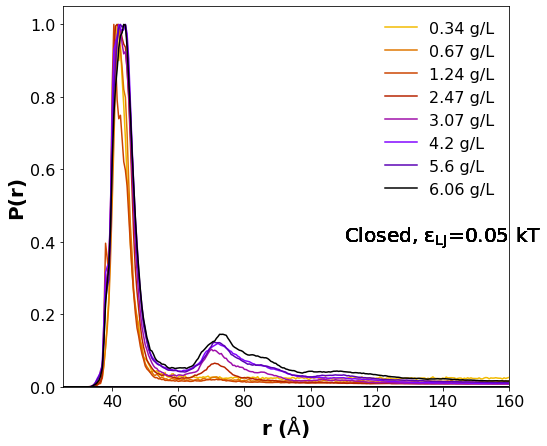

In [5]:
%cd -q $workdir/mc/data

serie = "series2"
conf = "closed"
epslj = 0.05
epshh = 0.61

for C in [0.34, 0.67, 1.24, 2.47, 3.07, 4.2, 5.6, 6.06]:
    if C == 0.34:
        col = '#f2bb00'
    elif C == 0.67:
        col = '#e07600'
    elif C == 1.24:
        col = '#cc4400'
    elif C == 2.47:
        col = '#b72300'
    elif C == 3.07:
        col = '#9e0ea9'
    elif C == 4.2:
        col = '#8104ff'
    elif C == 5.6:
        col = '#5a01b5'
    elif C == 6.06:
        col='black'

    nriter = 0
    pmoy = [0] * 7000
    rmoy = [0] * 7000
    pmax = [0] * 7000
    pmin = [1000] * 7000
    for dp in [0,1,2]:
        pfx = str(serie)+"-"+str(conf)+"-h"+str(epshh)+"-e"+str(epslj)+"-C"+str(C)+"-dp"+str(dp)
        %cd -q $pfx
        if path.exists("rdf.dat"):
            r,p = np.loadtxt("rdf.dat", unpack=True)
            nriter = nriter + 1   
            for i in np.arange(0,len(r),1):
                rmoy[i] = r[i]
                pmoy[i] = pmoy[i] + p[i]
                if pmax[i] < p[i]:
                    pmax[i] = p[i]
                if pmin[i] > p[i]:
                    pmin[i] = p[i]                    
        else:
            print("Missing data for", pfx)
        %cd -q '..' 
 
    for i in np.arange(0,len(r),1):
        pmoy[i] = pmoy[i]/nriter

    plt.plot(rmoy,pmoy/max(pmoy),color=col,label=str(C)+" g/L")
    plt.ylim(0.0,1.05)
    plt.xlim(25,160)
    plt.xlabel("r ("r'${\rm{\AA}}$'")", fontsize=20, weight='bold')
    plt.ylabel("P(r)", fontsize=20, weight='bold')
    plt.text(110,0.4, "Closed, "r'${\rm{\varepsilon_{LJ}}}$'"=0.05 kT", fontsize=20)
    plt.legend(frameon=False, loc=1)

%cd -q $workdir

## Regression for S(0)

Structure factors are fitted with a spline and S(0) is deduced from the fit curve. Different orders of the spline (1-5) and range of fit (0.13-0.3 $\mathring{A}^{−1}$ for the upper bound) are tested each time and the best one is kept. The average and standard deviation for the three repetitions of each condition is then printed out along with the plot of the original data and the fits (in blue).

-------------
TLL, closed , epsLJ = 0.05 kT, epsHH = 0.61 kT Cp = 0.34 g/L
Average S(0) = 1.037722415505658
Standard deviation = 0.020549122628642783
-------------
TLL, closed , epsLJ = 0.05 kT, epsHH = 0.61 kT Cp = 0.67 g/L
Average S(0) = 1.1160360022949414
Standard deviation = 0.027001845017622792
-------------
TLL, closed , epsLJ = 0.05 kT, epsHH = 0.61 kT Cp = 1.24 g/L
Average S(0) = 1.328640635349158
Standard deviation = 0.04697838169049779
-------------
TLL, closed , epsLJ = 0.05 kT, epsHH = 0.61 kT Cp = 2.47 g/L
Average S(0) = 2.4666058597807328
Standard deviation = 0.14018807966382033
-------------
TLL, closed , epsLJ = 0.05 kT, epsHH = 0.61 kT Cp = 3.07 g/L
Average S(0) = 3.891275848112366
Standard deviation = 0.2153191059768383
-------------
TLL, closed , epsLJ = 0.05 kT, epsHH = 0.61 kT Cp = 4.2 g/L
Average S(0) = 6.101365052327921
Standard deviation = 0.3630361325263964
-------------
TLL, closed , epsLJ = 0.05 kT, epsHH = 0.61 kT Cp = 5.6 g/L
Average S(0) = 7.53776986393452

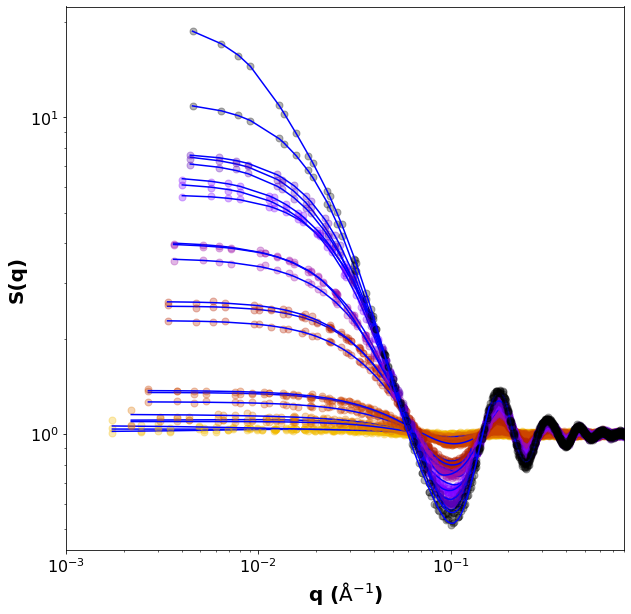

In [6]:
%cd -q $workdir/mc/data
from scipy import stats
plt.rcParams.update({'font.size': 16, 'figure.figsize': [10.0, 10.0]})

serie = "series2"
conf = "closed"
epslj = 0.05
epshh = 0.61

cp_list = []
invsmean_list = []
invsdev_list= []

for C in [0.34, 0.67, 1.24, 2.47, 3.07, 4.2, 5.6, 6.06]:
    if C == 0.34:
        col = '#f2bb00'
    elif C == 0.67:
        col = '#e07600'
    elif C == 1.24:
        col = '#cc4400'
    elif C == 2.47:
        col = '#b72300'
    elif C == 3.07:
        col = '#9e0ea9'
    elif C == 4.2:
        col = '#8104ff'
    elif C == 5.6:
        col = '#5a01b5'
    elif C == 6.06:
        col='black'

    limmin = 0.0
    s0_sum = 0
    s0_list = []
    invs0_list = []
    for dp in [0,1,2]:
        sumsquares_fin = 10000
        linmax_fin = 0
        kd_fin = 0
        r2_fin = 0
        s_fit_fin = []
        q_fit_fin = []
        s0_fin = 0
        
        pfx = str(serie)+"-"+str(conf)+"-h"+str(epshh)+"-e"+str(epslj)+"-C"+str(C)+"-dp"+str(dp)
        %cd -q $pfx
        if path.exists("debye_n2.dat"):
            q,s = np.loadtxt("debye_n2.dat", unpack=True)
            for limmax in np.arange(0.13,0.3,0.01):
                for kd in [1,2,3,4,5]: 
                    q_range = []
                    s_range = []
                    interceptlist = []
                    conclist = []
                    invs0list = []
                    for i in np.arange(0,len(q)):
                            if q[i] > limmin and q[i] < limmax:
                                q_range.append(q[i])
                                s_range.append(s[i])

                    q_array = np.array(q_range)
                    s_array = np.array(s_range)

                    fit = UnivariateSpline(q_array, s_array,k=kd)
                    fit.set_smoothing_factor(0.05)
                    abserror = fit(q_array) - s_array 
                    s_fit = fit(q_array)

                    sumsquares_res = np.sum(abserror**2)
                    sumsquares_tot = np.sum((s_array-np.mean(s_array))**2)
                    r2 = 1 - (sumsquares_res / sumsquares_tot)

                    if sumsquares_res < sumsquares_fin:
                        sumsquares_fin = sumsquares_res
                        limmax_fin = limmax
                        kd_fin = kd
                        r2_fin = r2
                        s_fit_fin = []
                        q_fit_fin = []
                        s_fit_fin = s_fit
                        q_fit_fin = q_array
                        s0_fin = fit(0)

            s0_list.append(s0_fin)
            invs0_list.append(1/s0_fin)
            plt.plot(q, s, ms=7, marker='o',ls='None', color=col, alpha=0.3, label=str(C)+" g/L")
            plt.plot(q_fit_fin,s_fit_fin,color='b')
        else:
            print('One rdf missing here')
            %cd -q '..'
            continue
            
        %cd -q '..'
    
    print("-------------")
    print("TLL,", conf, ", epsLJ =", epslj, "kT, epsHH =", epshh, "kT Cp =", C, "g/L")
    print("Average S(0) =", np.mean(s0_list)) 
    print("Standard deviation =", np.std(s0_list))
    cp_list.append(C)
    invsmean_list.append(np.mean(invs0_list))
    invsdev_list.append(np.std(invs0_list))

plt.xlim(0.001,0.8)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("q ("r'${\rm{\AA}^{-1}}$'")", fontsize=20, weight='bold')
plt.ylabel("S(q)", fontsize=20, weight='bold')
np.savetxt(str(serie)+"-"+str(conf)+"-e"+str(epslj)+'_s0.dat',np.transpose((cp_list,invsmean_list,invsdev_list)))

## Plot of S(0)=f(c) and B2 determination

The values of S(0) extracted from the previous step are plotted in function of protein concentration for each condition and a linear fit weighted by the standard deviation is applied. The value of B2 is deduced from the slope of the fit. The experimental data is also represented for comparison.

B2 closed, 0.05 =  -10.890847047020952
B2 closed, 0.005 =  -3.721912024366461
B2 open, 0.05 =  -5.420666547720568
B2 open, 0.005 =  -2.5778083778168934
[-0.03774606  0.96943766]
B2 experimental =  -5.437981895554401


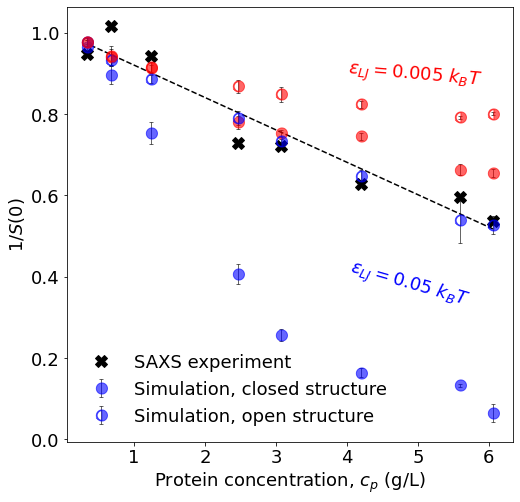

In [7]:
%cd -q $workdir/mc/data
plt.rcParams.update({'font.size': 18, 'figure.figsize': [8.0, 8.0]})
plt.tight_layout()

serie = "series2"

markersize=12
marker = ''
color='k'

for conf in ["closed", "open"]:
    for epslj in [0.05, 0.005]:
        if conf=="closed":  
            marker = '$●$'
        if conf=="open":
            marker = '$◑$'#'$◕$'
        if epslj==0.05:
            color='blue'
        if epslj==0.005:
            color='red'
        if epslj==0.05:
            label = 'Simulation, {} structure'.format(conf)
        else:
            label = ''
        cp, invs0_mean, invs0_dev = np.loadtxt(str(serie)+"-"+str(conf)+"-e"+str(epslj)+'_s0.dat', unpack=True)
        fit = np.polyfit(cp,invs0_mean,w=invs0_dev,deg=1)
        plt.errorbar(cp,invs0_mean, marker=marker, ls='None', ecolor='k', elinewidth=1,
                     capsize=2.0, color=color, ms=markersize, yerr=invs0_dev,
                     label=label, alpha=0.6)
        
        Mw = 29609.61
        N_A = 6.022*1e23
        A2 = fit[0]/(2*Mw)
        B2_raw = A2 * Mw**2 / N_A
        B2_hs = 2 * math.pi * (27.8*(10**-9)*2)**3 / 3
        print('B2 '+str(conf)+', '+str(epslj)+' = ', B2_raw/B2_hs)

plt.text(4, 0.87, r'$\varepsilon_{LJ} = 0.005~k_BT$', color='r', rotation=-5)
plt.text(4, 0.33, r'$\varepsilon_{LJ} = 0.05~k_BT$', color='b', rotation=-16)
        
# experiment
conc_s0, invs0_exp, s0_exp = np.loadtxt("s0_exp_series2.dat", usecols=(0,1,2), unpack=True)
fit2 = np.polyfit(conc_s0, invs0_exp,deg=1)
plt.plot(conc_s0, invs0_exp, marker='X', ls='None', ms=markersize, color='k', label="SAXS experiment", alpha=1)
A2 = fit2[0]/(2*Mw)
B2_raw = A2 * Mw**2 / N_A
B2_hs = 2 * math.pi * (27.8*(10**-9)*2)**3 / 3
plt.plot(conc_s0, fit2[0]*conc_s0+fit2[1], 'k--', alpha=1)
print(fit)
print('B2 experimental = ', B2_raw/B2_hs)
plt.legend(frameon=False, loc=3)
plt.xlabel("Protein concentration, $c_p$ (g/L)")
plt.ylabel("$1/S(0)$")
plt.savefig('one_over_sofzero.pdf', bbox_inches='tight')
plt.show()